Import the necessary libraries

In [81]:
!pip install transformers
!pip install ipywidgets
!pip install pytorch-lightning==1.5.10
!pip install nvidia-ml-py3
!pip install neptune-client
!pip install lightning-bolts
!pip install torchmetrics

  Using cached pytorch_lightning-1.5.10-py3-none-any.whl (527 kB)
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.9.5
    Uninstalling pytorch-lightning-1.9.5:
      Successfully uninstalled pytorch-lightning-1.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lightning-bolts 0.7.0 requires pytorch-lightning<2.0.0,>1.7.0, but you have pytorch-lightning 1.5.10 which is incompatible.
  Using cached pytorch_lightning-1.9.5-py3-none-any.whl (829 kB)
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.5.10
    Uninstalling pytorch-lightning-1.5.10:
      Successfully uninstalled pytorch-lightning-1.5.10


In [82]:
from transformers import Wav2Vec2Processor, Wav2Vec2Model, Wav2Vec2Config
import torch
from transformers.models.wav2vec2.modeling_wav2vec2 import Wav2Vec2FeatureEncoder, Wav2Vec2NoLayerNormConvLayer, Wav2Vec2LayerNormConvLayer
from torch import nn
from transformers.activations import ACT2FN
import ipywidgets
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import csv
import torchaudio
import torchtext
import pytorch_lightning as pl
import nvidia_smi
from pytorch_lightning.loggers.neptune import NeptuneLogger
from pytorch_lightning.loggers import NeptuneLogger
from IPython.display import display, HTML
from dataclasses import dataclass, field
from torch.utils.data import DataLoader
from typing import Any, Dict, List, Optional, Union
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR
from torchmetrics import Accuracy
from torchmetrics import F1Score
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
import numpy as np
import contextlib


Verify if the GPU is working

In [83]:
!nvidia-smi

Thu Nov  2 14:53:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:B3:00.0  On |                  Off |
| 42%   54C    P8    23W / 140W |   1411MiB / 16376MiB |     38%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [84]:
print(f"Pytorch Lightning Version: {pl.__version__}")
nvidia_smi.nvmlInit()
handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
print(f"Device name: {nvidia_smi.nvmlDeviceGetName(handle)}")

Pytorch Lightning Version: 1.9.5
Device name: b'NVIDIA RTX A4000'


Define hyperparameters

In [85]:
version = "wav2vec2-sound_sismic_train" #@param {type: "string"}
lr = 1e-5#@param {type: "number"}
w_decay = 0#@param {type: "number"}
bs = 16#@param {type: "integer"}
accum_grads = 4#@param {type: "integer"}
patience = 30#@param {type: "integer"}
max_epochs = 300#@param {type: "integer"}
# warmup_steps = 1000#@param {type: "integer"}
hold_epochs = 20#@param {type: "integer"}
pretrained = "facebook/wav2vec2-base-960h"#@param {type: "string"}
wav2vec2_processor = "facebook/wav2vec2-base-960h"#@param {type: "string"}
freeze_finetune_updates = 5#@param {type: "integer"}
warmup_epochs = 40#@param {type: "integer"}
apply_mask=False#@param {type: "boolean"}
mask_time_length= 10#@param {type: "integer"}, era 1

# Define hyperparameters
hparams = {"version": version,
          "lr": lr,
          "w_decay": w_decay,
          "bs": bs,
          "patience": patience,
          "hold_epochs":hold_epochs,
          "accum_grads": accum_grads,
          "pretrained":pretrained,
          "wav2vec2_processor": wav2vec2_processor,
          "freeze_finetune_updates":freeze_finetune_updates,
          "warmup_epochs":warmup_epochs,
          "apply_mask":apply_mask,
          "mask_time_length":mask_time_length,
          "max_epochs": max_epochs}
hparams

{'version': 'wav2vec2-sound_sismic_train',
 'lr': 1e-05,
 'w_decay': 0,
 'bs': 16,
 'patience': 30,
 'hold_epochs': 20,
 'accum_grads': 4,
 'pretrained': 'facebook/wav2vec2-base-960h',
 'wav2vec2_processor': 'facebook/wav2vec2-base-960h',
 'freeze_finetune_updates': 5,
 'warmup_epochs': 40,
 'apply_mask': False,
 'mask_time_length': 10,
 'max_epochs': 300}

Use the original processor from Wav2Vec2

In [86]:
processor = Wav2Vec2Processor.from_pretrained(hparams["wav2vec2_processor"], return_attention_mask=True)

In [87]:
print(processor)

Wav2Vec2Processor:
- feature_extractor: Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": true,
  "sampling_rate": 16000
}

- tokenizer: PreTrainedTokenizer(name_or_path='facebook/wav2vec2-base-960h', vocab_size=32, model_max_len=9223372036854775807, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'})


Generalize the model to accept n channels instead of just 1

In [88]:
class Wav2Vec2GroupNormConvLayer(nn.Module):
    def __init__(self, config, num_input_channels=1, layer_id=0):
        super().__init__()
        self.num_input_channels = num_input_channels
        self.in_conv_dim = config.conv_dim[layer_id - 1] if layer_id > 0 else self.num_input_channels
        self.out_conv_dim = config.conv_dim[layer_id]

        self.conv = nn.Conv1d(
            self.in_conv_dim,
            self.out_conv_dim,
            kernel_size=config.conv_kernel[layer_id],
            stride=config.conv_stride[layer_id],
            bias=config.conv_bias,
        )
        self.activation = ACT2FN[config.feat_extract_activation]

        self.layer_norm = nn.GroupNorm(num_groups=self.out_conv_dim, num_channels=self.out_conv_dim, affine=True)

    def forward(self, hidden_states):
        hidden_states = self.conv(hidden_states)
        hidden_states = self.layer_norm(hidden_states)
        hidden_states = self.activation(hidden_states)
        return hidden_states

class Wav2Vec2_ChannelFeatureEncoder(nn.Module):
    """Construct the features from raw audio waveform"""

    def __init__(self, config, num_input_channels=1):
        super().__init__()
        
        self.num_input_channels = num_input_channels
        
        if config.feat_extract_norm == "group":
            conv_layers = [Wav2Vec2GroupNormConvLayer(config, num_input_channels= self.num_input_channels,layer_id=0)] + [
                Wav2Vec2NoLayerNormConvLayer(config, layer_id=i + 1) for i in range(config.num_feat_extract_layers - 1)
            ]
        elif config.feat_extract_norm == "layer":
            conv_layers = [
                Wav2Vec2LayerNormConvLayer(config, layer_id=i) for i in range(config.num_feat_extract_layers)
            ]
        else:
            raise ValueError(
                f"`config.feat_extract_norm` is {config.feat_extract_norm}, but has to be one of ['group', 'layer']"
            )
        self.conv_layers = nn.ModuleList(conv_layers)
        self.gradient_checkpointing = False
        self._requires_grad = True

    def _freeze_parameters(self):
        for param in self.parameters():
            param.requires_grad = False
        self._requires_grad = False

    def forward(self, input_values):
        hidden_states = input_values[:] # mudou para que receba todos os canais (4)
        #print("hidden_states", hidden_states.shape)

        # make sure hidden_states require grad for gradient_checkpointing
        if self._requires_grad and self.training:
            hidden_states.requires_grad = True

        for conv_layer in self.conv_layers:
            if self._requires_grad and self.gradient_checkpointing and self.training:

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs)

                    return custom_forward

                hidden_states = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(conv_layer),
                    hidden_states,
                )
            else:
                hidden_states = conv_layer(hidden_states)

        return hidden_states

# Crio o novo modelo que herda os processos de Wav2Vec2, mas usa o extrator de features baseado em 4 canais
class Wav2Vec2_ChannelModel(Wav2Vec2Model):
    def __init__(self, config: Wav2Vec2Config, num_input_channels=1):
        super().__init__(config)

        #del self.feature_extractor
        self.feature_extractor = Wav2Vec2_ChannelFeatureEncoder(config, num_input_channels=num_input_channels)

In [89]:
model = Wav2Vec2_ChannelModel.from_pretrained("facebook/wav2vec2-base-960h",
                                                 conv_dim = (512, 512, 512,512,512,512),
                                                 conv_stride = (5, 2, 2,2,2,2),
                                                 conv_kernel = (10, 3, 3,3,3,2),
                                                 num_feat_extract_layers = 6,
                                                 num_input_channels = 1,
                                                 ignore_mismatched_sizes=True)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2_ChannelModel: ['lm_head.bias', 'lm_head.weight', 'wav2vec2.feature_extractor.conv_layers.6.conv.weight']
- This IS expected if you are initializing Wav2Vec2_ChannelModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2_ChannelModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2_ChannelModel were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [90]:
print(model)

Wav2Vec2_ChannelModel(
  (feature_extractor): Wav2Vec2_ChannelFeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5): Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmb

DO THE TRAIN-TEST SPLIT

In [91]:
#from sklearn.model_selection import train_test_split
#import os
#import shutil
#import librosa

# #Define la ruta de la carpeta que contiene los archivos de audio
#input_folder = '/media/cslab03/TOSHIBA EXT/TESIS/DataSet/AudioSismig1/'

# #Lista todos los archivos de la carpeta
#files = [os.path.join(input_folder, file) for file in os.listdir(input_folder)]

# #Define las proporciones para train, test y validation sets
#train_ratio = 0.7
#test_ratio = 0.15
#validation_ratio = 0.15

# ##Divide los datos en train, test y validation sets
#train_files, temp_files = train_test_split(files, test_size=1 - train_ratio)
#test_files, validation_files = train_test_split(temp_files, test_size=validation_ratio / (test_ratio + validation_ratio))

 #Define las carpetas de salida
#output_folder = './data1/'
#os.makedirs(os.path.join(output_folder, 'train'), exist_ok=True)
#os.makedirs(os.path.join(output_folder, 'test'), exist_ok=True)
#os.makedirs(os.path.join(output_folder, 'validation'), exist_ok=True)


 #Copia los archivos a las carpetas correspondientes
#for file in train_files:
#    if 'BHZ' in file:    
#        try:
#            audio, _ = librosa.load(file, sr=None)
#            shutil.copy(file, os.path.join(output_folder, 'train'))
#        except Exception as e:
#            print(e)
#            print(file)
#    else:
#        continue
    
#for file in test_files:
#    if 'BHZ' in file:
#        try:
#            audio, _ = librosa.load(file, sr=None)
#            shutil.copy(file, os.path.join(output_folder, 'test'))
#        except Exception as e:
#            print(e)
#            print(file)
#    else:
#        continue
    
#for file in validation_files:
#    if 'BHZ' in file:
#        try:
#            audio, _ = librosa.load(file, sr=None)
#            shutil.copy(file, os.path.join(output_folder, 'validation'))
#        except Exception as e:
#            print(e)
#            print(file)
#    else:
#        continue

#print("Data split completed.")


In [221]:
from sklearn.model_selection import train_test_split
import os
import shutil
import librosa

# Define la ruta de la carpeta que contiene los archivos de audio
input_folder = '/home/cslab03/Desktop/QuakeWavNet/test_audios/'

# Lista todos los archivos de la carpeta
files = [os.path.join(input_folder, file) for file in os.listdir(input_folder)]

# Filtra los archivos 'LP' y 'VT'
lp_files = [file for file in files if '_00.wav' in file]
vt_files = [file for file in files if '_01.wav' in file]

print(f'LP files: {len(lp_files)}')
print(f'VT files: {len(vt_files)}')
# Define las proporciones para train, test y validation sets
train_ratio = 0.7
test_ratio = 0.15
validation_ratio = 0.15

# Divide los datos en train, test y validation sets
lp_train_files, lp_temp_files = train_test_split(lp_files, test_size=1 - train_ratio)
lp_test_files, lp_validation_files = train_test_split(lp_temp_files, test_size=validation_ratio / (test_ratio + validation_ratio))

vt_train_files, vt_temp_files = train_test_split(vt_files, test_size=1 - train_ratio)
vt_test_files, vt_validation_files = train_test_split(vt_temp_files, test_size=validation_ratio / (test_ratio + validation_ratio))

# Define las carpetas de salida
output_folder = './data2/'
os.makedirs(os.path.join(output_folder, 'train'), exist_ok=True)
os.makedirs(os.path.join(output_folder, 'test'), exist_ok=True)
os.makedirs(os.path.join(output_folder, 'validation'), exist_ok=True)

# Copia los archivos 'LP' a las carpetas correspondientes
for file in lp_train_files:
    try:
        audio, _ = librosa.load(file, sr=None)
        shutil.copy(file, os.path.join(output_folder, 'train'))
    except Exception as e:
        print(e)
        print(file)

for file in lp_test_files:
    try:
        audio, _ = librosa.load(file, sr=None)
        shutil.copy(file, os.path.join(output_folder, 'test'))
    except Exception as e:
        print(e)
        print(file)

for file in lp_validation_files:
    try:
        audio, _ = librosa.load(file, sr=None)
        shutil.copy(file, os.path.join(output_folder, 'validation'))
    except Exception as e:
        print(e)
        print(file)

# Copia los archivos 'VT' a las carpetas correspondientes
for file in vt_train_files:
    try:
        audio, _ = librosa.load(file, sr=None)
        shutil.copy(file, os.path.join(output_folder, 'train'))
    except Exception as e:
        print(e)
        print(file)

for file in vt_test_files:
    try:
        audio, _ = librosa.load(file, sr=None)
        shutil.copy(file, os.path.join(output_folder, 'test'))
    except Exception as e:
        print(e)
        print(file)

for file in vt_validation_files:
    try:
        audio, _ = librosa.load(file, sr=None)
        shutil.copy(file, os.path.join(output_folder, 'validation'))
    except Exception as e:
        print(e)
        print(file)


In [217]:
class ANSYN_Dataset_SE(torch.utils.data.Dataset):

    def __init__(self, filenames, audio_path):
        self.filenames = [filename for filename in filenames if not any(substring in filename for substring in ['TRBA', 'EXPL', 'VLP', 'TRESP','HB'])]
        self.audio_path = audio_path
    
    def process_audio(self, signal, new_sr):
        # right pad if necessary
        length_signal = signal.shape[1]
        if length_signal < 17787:
            num_missing_samples = 17787 - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        elif length_signal > 17787:
            signal = signal[:, :17787]
            
        return signal
    

    def normalize_layer(self, feats):
        with torch.no_grad():
            feats = torch.nn.functional.layer_norm(feats, feats.shape)
        return feats

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        # Intenta cargar el archivo de audio
        feats, _ = torchaudio.load(self.audio_path + self.filenames[index])


        # Asigna una etiqueta de destino basada en el nombre del archivo
        if 'LP' or '_00.wav' in self.filenames[index]:
            target = torch.tensor(int('00')).long() 
        elif 'VT' or '_01.wav' in self.filenames[index]:
            target = torch.tensor(int('01')).long()
                    
        feats = self.process_audio(feats, 16000)
        feats = self.normalize_layer(feats)
        
        return {"input_values": feats, "target": target}
        

In [222]:
X_train = os.listdir('/home/cslab03/Desktop/QuakeWavNet/data2/train/')
X_test = os.listdir('/home/cslab03/Desktop/QuakeWavNet/data2/test/')
X_val = os.listdir('/home/cslab03/Desktop/QuakeWavNet/data2/validation/')

In [223]:
print(X_train[0])

EC_BREF_900_00.wav


In [224]:
train_dataset = ANSYN_Dataset_SE(X_train, '/home/cslab03/Desktop/QuakeWavNet/data2/train/')
val_dataset =  ANSYN_Dataset_SE(X_val, '/home/cslab03/Desktop/QuakeWavNet/data2/validation/')
test_dataset = ANSYN_Dataset_SE(X_test, '/home/cslab03/Desktop/QuakeWavNet/data2/test/')

In [225]:
train_dataset.__getitem__(0)

{'input_values': tensor([[-1.1488e-01, -1.1383e-01, -1.1111e-01,  ..., -9.2828e-05,
          -9.2828e-05, -9.2828e-05]]),
 'target': tensor(0)}

In [226]:
print('Número de amostras de treinamento:', len(train_dataset))
print('Número de amostras de validação:', len(val_dataset))
print('Número de amostras de teste:', len(test_dataset))

Número de amostras de treinamento: 800
Número de amostras de validação: 173
Número de amostras de teste: 172


In [227]:
label_distribution = {}
for data in train_dataset:
    label = data["target"].item()
    
    if label == 0:
        label = "LP"
    elif label == 1:
        label = "VT"

        
    if label in label_distribution:
        label_distribution[label] += 1
    else:
        label_distribution[label] = 1

    
print("Label distribution:")
print(label_distribution)


Label distribution:
{'LP': 800}


In [99]:
target_sampling_rate = processor.feature_extractor.sampling_rate
print(f"Frequência de amostragem aceita pelo modelo: {target_sampling_rate}")
# Conferindo se os dados de entrada não geram erro no processor
inputs = processor(train_dataset[5]["input_values"], sampling_rate=target_sampling_rate, return_tensors="pt")
print(f'Input values dimensão: {inputs["input_values"].shape}')
print(inputs)

Frequência de amostragem aceita pelo modelo: 16000
Input values dimensão: torch.Size([1, 1, 17787])
{'input_values': tensor([[[-0.0519, -0.0224, -0.0146,  ...,  0.6665,  0.6665,  0.6665]]]), 'attention_mask': tensor([[1]], dtype=torch.int32)}


In [100]:
print('Dimensões de entrada do modelo:')
with torch.no_grad():
    outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

print('Dimensões de saída do modelo: \n',last_hidden_states.shape)

Dimensões de entrada do modelo:
Dimensões de saída do modelo: 
 torch.Size([1, 110, 768])


In [101]:
@dataclass
class DataCollatorWithPadding:
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None
@dataclass
class DataCollatorWithPadding:
     """
     Data collator that will dynamically pad the inputs received.
     Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
             The processor used for proccessing the data.
         padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
             Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
             among:
             * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
               sequence if provided).
             * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
               maximum acceptable input length for the model if that argument is not provided.
             * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
               different lengths).
         max_length (:obj:`int`, `optional`):
             Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
         max_length_labels (:obj:`int`, `optional`):
             Maximum length of the ``labels`` returned list and optionally padding length (see above).
         pad_to_multiple_of (:obj:`int`, `optional`):
             If set will pad the sequence to a multiple of the provided value.
             This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
             7.5 (Volta).
     """
     processor: Wav2Vec2Processor
     padding: Union[bool, str] = True
     max_length: Optional[int] = None
     max_length_labels: Optional[int] = None
     pad_to_multiple_of: Optional[int] = None
     pad_to_multiple_of_labels: Optional[int] = None

     def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
                
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["target"]} for feature in features]
        batch = self.processor.pad(
             input_features,
             padding=self.padding,
             max_length=self.max_length,
             pad_to_multiple_of=self.pad_to_multiple_of,
             return_tensors="pt",
         )
        #print('batch', batch)
        with self.processor.as_target_processor(): labels_batch = self.processor.pad( label_features, padding=True,max_length=self.max_length_labels,pad_to_multiple_of=self.pad_to_multiple_of_labels,return_tensors="pt",)
        #print('labels_batch', labels_batch)

        labels = labels_batch["input_ids"]

        batch["target"] = labels

        return batch

In [102]:
data_collator = DataCollatorWithPadding(processor=processor,
                                        #max_length=188,
                                        padding=True)

In [103]:
batch_size = hparams["bs"]

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                              collate_fn = data_collator,
                              shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size,
                            collate_fn = data_collator,
                            shuffle=False, num_workers=4)

print('Número de minibatches de treinamento:', len(train_dataloader))
print('Número de minibatches de validação:', len(val_dataloader))

batch = next(iter(train_dataloader))
#print(batch)

x_train, y_train = batch['input_values'], batch['target']
print("\nDimensões dos dados de um minibatch - Audio:", x_train.size())
# print("\nDimensões dos dados de um minibatch:", padding_mask.size())
print("\nDimensões dos dados de um minibatch - Target:", y_train.size())
print("Valores mínimo e máximo entrada: ", torch.min(x_train), torch.max(x_train))
print("Valores mínimo e máximo saída: ", torch.min(y_train), torch.max(y_train))
print("Tipo dos dados dos áudios:         ", type(x_train))
print("Tipo das classes das classes:       ", type(y_train))

Número de minibatches de treinamento: 888
Número de minibatches de validação: 194

Dimensões dos dados de um minibatch - Audio: torch.Size([16, 1, 17787])

Dimensões dos dados de um minibatch - Target: torch.Size([16])
Valores mínimo e máximo entrada:  tensor(-11.8406) tensor(10.2077)
Valores mínimo e máximo saída:  tensor(0) tensor(1)
Tipo dos dados dos áudios:          <class 'torch.Tensor'>
Tipo das classes das classes:        <class 'torch.Tensor'>


In [104]:
batch

{'input_values': tensor([[[-0.3025, -0.5815, -0.4765,  ...,  1.0512,  1.0512,  1.0512]],

        [[-0.0137, -0.0951, -0.0526,  ...,  0.2149,  0.2149,  0.2149]],

        [[-0.1345, -0.0787, -0.0981,  ..., -0.2318, -0.2318, -0.2318]],

        ...,

        [[ 0.2901,  0.2758,  0.2682,  ..., -0.6804, -0.6804, -0.6804]],

        [[-0.9574, -0.9205, -0.9159,  ..., -0.4329, -0.4329, -0.4329]],

        [[ 0.6422,  0.6431,  0.6142,  ..., -0.2019, -0.2019, -0.2019]]]), 'attention_mask': tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=torch.int32), 'target': tensor([0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0])}

In [105]:
next(iter(train_dataloader))

{'input_values': tensor([[[-0.0500, -0.1228, -0.2434,  ...,  0.5532,  0.5532,  0.5532]],

        [[-0.5624, -0.8196, -1.0067,  ...,  0.0106,  0.0106,  0.0106]],

        [[-0.2420, -0.2143, -0.1788,  ...,  2.4349,  2.4349,  2.4349]],

        ...,

        [[-1.8149, -1.9337, -1.8024,  ...,  1.4282,  1.4282,  1.4282]],

        [[ 0.2914,  0.3744,  0.3977,  ...,  0.2768,  0.2768,  0.2768]],

        [[-0.2104, -0.1962, -0.1809,  ...,  2.9145,  2.9145,  2.9145]]]), 'attention_mask': tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=torch.int32), 'target': tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1])}

In [106]:
n_classes = 2
f1 = F1Score(num_classes=n_classes, average='macro', task='multiclass')
accuracy = Accuracy(num_classes=n_classes,task='multiclass')

In [107]:
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics import ConfusionMatrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import io
import torchvision

In [108]:
logger = TensorBoardLogger("metrics", name="my_experiment_name")

In [109]:
class Wav2Vec2_sound_detection(pl.LightningModule):
    def __init__(self, *args, **kwargs):
        super().__init__()

        self.hparams.update(hparams)

        self.freeze_finetune_updates = hparams["freeze_finetune_updates"]
                
        self.train_losses = [] 
        self.val_losses = []
        self.val_f1_scores = []
        self.test_f1_scores = []
        self.confussion_matrix = None
        
        self.model = Wav2Vec2_ChannelModel.from_pretrained(hparams["pretrained"],
                                                 conv_dim = (512, 512, 512, 512, 512, 512),
                                                 conv_stride = (5, 2, 2, 2, 2, 2),
                                                 conv_kernel = (10, 3, 3, 3, 3, 2),
                                                 num_feat_extract_layers = 6,
                                                 apply_spec_augment=hparams["apply_mask"],
                                                 #mask_time_length=hparams["mask_time_length"],
                                                 num_input_channels = 1,
                                                 ignore_mismatched_sizes=True)


        self.model.feature_extractor._freeze_parameters()

        # freeze base-model
        for param in self.model.parameters():
            param.requires_grad = False

        self.projector = nn.Linear(self.model.config.hidden_size, self.model.config.classifier_proj_size)
        n_classes = 2
        self.final_layer = nn.Linear(self.model.config.classifier_proj_size, n_classes)
        self.logger_initialized = False
    
    def initialize_logger(self, logger):
        self.logger = logger
        self.logger_initialized = True

    def forward(self, samples):
                
        
        ft = self.freeze_finetune_updates <= self.trainer.global_step

        with torch.no_grad() if not ft else contextlib.ExitStack():
            hidden_states = self.model(**samples).last_hidden_state

        padding_mask = self.model._get_feature_vector_attention_mask(hidden_states.shape[1], samples["attention_mask"])

        hidden_states[~padding_mask] = 0.0

        pooled_output = hidden_states.sum(dim=1) / padding_mask.sum(dim=1).view(-1, 1)

        proj_pooled = self.projector(pooled_output)

        preds = self.final_layer(proj_pooled)

        return F.log_softmax(preds, dim=1)

    def _get_feature_vector_attention_mask(self, feature_vector_length: int, attention_mask: torch.LongTensor):
        output_lengths = self._get_feat_extract_output_lengths(attention_mask.sum(-1)).to(torch.long)
        batch_size = attention_mask.shape[0]

        attention_mask = torch.zeros(
            (batch_size, feature_vector_length), dtype=attention_mask.dtype, device=attention_mask.device
        )

        attention_mask[(torch.arange(attention_mask.shape[0], device=attention_mask.device), output_lengths - 1)] = 1
        attention_mask = attention_mask.flip([-1]).cumsum(-1).flip([-1]).bool()
        return attention_mask
        
        
    def training_step(self, train_batch, batch_idx):

        y_value = train_batch.pop("target")
        log_softs = self.forward(train_batch)
    

        loss = F.nll_loss(log_softs, y_value)

        self.log('loss_step', loss, on_step=True, prog_bar=True)
        
        
        #self.logger.log_metrics({'train_loss': loss.item()}, step=self.global_step)

        return loss

    def training_epoch_end(self, outputs):
        loss = torch.stack([x['loss'] for x in outputs]).mean()
        

        self.log("train_loss", loss, prog_bar=True)
        self.train_losses.append(loss.item())
        
        self.logger.log_metrics({'train_loss_epoch': loss.item()}, step=self.current_epoch)
        

    def validation_step(self, val_batch, batch_idx):

        y_value = val_batch.pop("target")

        log_softs = self.forward(val_batch)
        preds = torch.argmax(log_softs, dim=1)

        val_acc = accuracy(preds.cpu(), y_value.cpu())
        val_f1 = f1(preds.cpu(), y_value.cpu())
        val_loss = F.nll_loss(log_softs, y_value)

        self.log('val_acc', val_acc, prog_bar=True)
        self.log('val_f1', val_f1, prog_bar=True)
        self.log('val_loss', val_loss, prog_bar=True)
        
        
        
        #self.logger.log_metrics({'val_acc': val_acc, 'val_f1': val_f1, 'val_loss': val_loss.item()}, step=self.global_step)

        return {"val_acc_step": val_acc, "val_f1_step": val_f1, "val_loss_step": val_loss}

    
    def validation_epoch_end(self, outputs):
        acc_mean = torch.stack([x['val_acc_step'] for x in outputs]).mean()
        f1_mean = torch.stack([x['val_f1_step'] for x in outputs]).mean()
        loss_mean = torch.stack([x['val_loss_step'] for x in outputs]).mean()
                

        self.log("val_acc", acc_mean, prog_bar=True)
        self.log("val_f1", f1_mean, prog_bar=True)
        self.log("val_loss", loss_mean, prog_bar=True)

        self.val_f1_scores.append(f1_mean)
        self.val_losses.append(loss_mean.item())
        
        self.logger.log_metrics({'val_acc_epoch': acc_mean, 'val_f1_epoch': f1_mean, 'val_loss_epoch': loss_mean.item()}, step=self.current_epoch)
        
    #import torch.functional as F
    
    """def validation_epoch_end(self, outputs):
        acc_mean = torch.stack([x['val_acc_step'] for x in outputs]).mean()
        f1_mean = torch.stack([x['val_f1_step'] for x in outputs]).mean()
        loss_mean = torch.stack([x['val_loss_step'] for x in outputs]).mean()

        self.log("val_acc", acc_mean, prog_bar=True)
        self.log("val_f1", f1_mean, prog_bar=True)
        self.log("val_loss", loss_mean, prog_bar=True)"""

    def test_step(self, test_batch, batch_idx):

        y_value = test_batch.pop("target")

        log_softs = self.forward(test_batch)
        preds = torch.argmax(log_softs, dim=1)

        test_acc = accuracy(preds.cpu(), y_value.cpu())
        test_f1 = f1(preds.cpu(), y_value.cpu())
        test_loss = F.nll_loss(log_softs, y_value)

        self.log('test_acc', test_acc, prog_bar=True)
        self.log('test_f1', test_f1, prog_bar=True)
        self.log('test_loss', test_loss, prog_bar=True)
        
        #self.logger.log_metrics({'test_acc': test_acc, 'test_f1': test_f1, 'test_loss': test_loss.item()}, step=self.global_step)
        
        return {"test_acc_step": test_acc, "test_f1_step": test_f1,  "test_loss_step": test_loss, "preds": preds, "y_value": y_value}

    def test_epoch_end(self, outputs):
        acc_mean = torch.stack([x['test_acc_step'] for x in outputs]).mean()
        f1_mean = torch.stack([x['test_f1_step'] for x in outputs]).mean()
        loss_mean = torch.stack([x['test_loss_step'] for x in outputs]).mean()
        

        self.log("test_acc", acc_mean, prog_bar=True)
        self.log("test_f1", f1_mean, prog_bar=True)
        self.log("test_loss", loss_mean, prog_bar=True)
        
        self.test_f1_scores.append(f1_mean)
        all_preds = torch.cat([x['preds'] for x in outputs])
        all_targets = torch.cat([x['y_value'] for x in outputs])
                
        confusion_matrix_tb = ConfusionMatrix(num_classes=n_classes, task='multiclass')
        confusion_matrix_tb(all_preds.cpu(), all_targets.cpu())
        
        print(confusion_matrix_tb)
        
        computed_confusion = confusion_matrix_tb.compute().detach().cpu().numpy().astype(int)
        
        df_cm = pd.DataFrame(
            computed_confusion,
        )

        fig, ax = plt.subplots(figsize=(10, 5))
        fig.subplots_adjust(left=0.05, right=.65)
        sns.set(font_scale=1.2)
        sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d', ax=ax)
        
        buf = io.BytesIO()

        plt.savefig(buf, format='jpeg', bbox_inches='tight')
        buf.seek(0)
        im = Image.open(buf)
        im = torchvision.transforms.ToTensor()(im)
                    
        self.logger.log_metrics({'test_acc_epoch': acc_mean, 'test_f1_epoch': f1_mean, 'test_loss_epoch': loss_mean.item()}, step=self.current_epoch)
        self.logger.experiment.add_image('confusion_matrix', im, global_step=self.global_step)
    
    
    def configure_optimizers(self):

        optimizer = torch.optim.Adam(self.parameters(),
                         lr=self.hparams["lr"],
                         betas=(0.9,0.98),
                         eps=1e-6,
                         weight_decay=self.hparams["w_decay"])

        scheduler = LinearWarmupCosineAnnealingLR(optimizer,
                                                  eta_min=0,
                                                  warmup_start_lr=self.hparams["lr"],
                                                  warmup_epochs=self.hparams["warmup_epochs"],
                                                  max_epochs=self.hparams["max_epochs"])

        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [110]:
neptune_logger = NeptuneLogger(
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjMWEyNTJlZS05ZDI5LTQzZjktYTkzNy00MDczMmZhODU3OWUifQ==",
    project='kgrosero/IA025-Project-wav2vec2')

In [111]:
#model = Wav2Vec2_sound_detection(hparams)

#trainer = pl.Trainer(gpus=1,
#                     logger=neptune_logger,
 #                    max_epochs=100,
  #                  overfit_batches=3,
   #                 log_every_n_steps = 1)

#trainer.fit(model, train_dataloader, val_dataloader)
#del model, trainer # Para não ter estouro de mémoria da GPU
#gc.collect()
#torch.cuda.empty_cache()

In [121]:
pl_model= Wav2Vec2_sound_detection(hparams=hparams, logger = logger)
checkpoint_path = '/home/cslab03/Desktop/QuakeWavNet/Results/'
checkpoint_dir = os.path.dirname(os.path.abspath(checkpoint_path))
print(f'Files in {checkpoint_path}: {os.listdir(checkpoint_path)}')
print(f'Saving checkpoints to {checkpoint_path}')
checkpoint_callback = pl.callbacks.ModelCheckpoint(filename=hparams["version"],
                                                  dirpath=checkpoint_dir,
                                                  save_top_k=1,
                                                  verbose = True,
                                                  monitor="val_f1", mode="max")
early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_f1", patience=hparams["patience"], mode='max')
early_stop_callback_1 = pl.callbacks.EarlyStopping(monitor="val_loss", patience=hparams["patience"], mode='max')
callbacks_list = [early_stop_callback]
lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval='step')

trainer = pl.Trainer(gpus=1,
                     precision=16,
                     logger=logger,
                     num_sanity_val_steps=0,
                     accumulate_grad_batches=hparams["accum_grads"],
                     enable_checkpointing=True,
                     callbacks=callbacks_list + [lr_monitor, checkpoint_callback],
                     max_epochs=300)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2_ChannelModel: ['lm_head.bias', 'lm_head.weight', 'wav2vec2.feature_extractor.conv_layers.6.conv.weight']
- This IS expected if you are initializing Wav2Vec2_ChannelModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2_ChannelModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2_ChannelModel were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/cslab03/anaconda3/

Files in /home/cslab03/Desktop/QuakeWavNet/Results/: ['wav2vec2-sound_sismic_train']
Saving checkpoints to /home/cslab03/Desktop/QuakeWavNet/Results/


In [122]:
# Definir listas para almacenar las métricas por época
train_losses = []
val_losses = []
val_f1_scores = []

torch.cuda.empty_cache()

trainer.fit(pl_model, train_dataloader, val_dataloader)

You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/cslab03/anaconda3/envs/coEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/cslab03/Desktop/QuakeWavNet exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/tmp/ipykernel_26758/3739991269.py:215: UnderReviewWarning: The feature LinearWarmupCosineAnnealingLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More det

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 222: 'val_f1' reached 0.37292 (best 0.37292), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 444: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 666: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 888: 'val_f1' reached 0.37357 (best 0.37357), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 1110: 'val_f1' reached 0.37532 (best 0.37532), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 1332: 'val_f1' reached 0.38038 (best 0.38038), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 1554: 'val_f1' reached 0.39121 (best 0.39121), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 1776: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 1998: 'val_f1' reached 0.39639 (best 0.39639), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 2220: 'val_f1' reached 0.40558 (best 0.40558), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 2442: 'val_f1' reached 0.41459 (best 0.41459), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 2664: 'val_f1' reached 0.44483 (best 0.44483), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 2886: 'val_f1' reached 0.46457 (best 0.46457), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 3108: 'val_f1' reached 0.47645 (best 0.47645), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 3330: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 3552: 'val_f1' reached 0.48573 (best 0.48573), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 3774: 'val_f1' reached 0.50131 (best 0.50131), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 3996: 'val_f1' reached 0.52138 (best 0.52138), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 4218: 'val_f1' reached 0.54433 (best 0.54433), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 4440: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 4662: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 4884: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 5106: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 5328: 'val_f1' reached 0.55708 (best 0.55708), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 5550: 'val_f1' reached 0.55781 (best 0.55781), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 5772: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 5994: 'val_f1' reached 0.56234 (best 0.56234), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 6216: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 6438: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 29, global step 6660: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 30, global step 6882: 'val_f1' reached 0.56348 (best 0.56348), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 31, global step 7104: 'val_f1' reached 0.56795 (best 0.56795), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 32, global step 7326: 'val_f1' reached 0.57567 (best 0.57567), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 33, global step 7548: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 34, global step 7770: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 35, global step 7992: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 36, global step 8214: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 37, global step 8436: 'val_f1' reached 0.58126 (best 0.58126), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 38, global step 8658: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 39, global step 8880: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 40, global step 9102: 'val_f1' reached 0.58158 (best 0.58158), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 41, global step 9324: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 42, global step 9546: 'val_f1' reached 0.58196 (best 0.58196), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 43, global step 9768: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 44, global step 9990: 'val_f1' reached 0.58544 (best 0.58544), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 45, global step 10212: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 46, global step 10434: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 47, global step 10656: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 48, global step 10878: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 49, global step 11100: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 50, global step 11322: 'val_f1' reached 0.58731 (best 0.58731), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 51, global step 11544: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 52, global step 11766: 'val_f1' reached 0.58825 (best 0.58825), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 53, global step 11988: 'val_f1' reached 0.58854 (best 0.58854), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 54, global step 12210: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 55, global step 12432: 'val_f1' reached 0.59579 (best 0.59579), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 56, global step 12654: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 57, global step 12876: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 58, global step 13098: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 59, global step 13320: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 60, global step 13542: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 61, global step 13764: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 62, global step 13986: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 63, global step 14208: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 64, global step 14430: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 65, global step 14652: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 66, global step 14874: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 67, global step 15096: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 68, global step 15318: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 69, global step 15540: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 70, global step 15762: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 71, global step 15984: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 72, global step 16206: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 73, global step 16428: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 74, global step 16650: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 75, global step 16872: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 76, global step 17094: 'val_f1' reached 0.60121 (best 0.60121), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 77, global step 17316: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 78, global step 17538: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 79, global step 17760: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 80, global step 17982: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 81, global step 18204: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 82, global step 18426: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 83, global step 18648: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 84, global step 18870: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 85, global step 19092: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 86, global step 19314: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 87, global step 19536: 'val_f1' reached 0.60230 (best 0.60230), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 88, global step 19758: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 89, global step 19980: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 90, global step 20202: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 91, global step 20424: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 92, global step 20646: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 93, global step 20868: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 94, global step 21090: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 95, global step 21312: 'val_f1' reached 0.60418 (best 0.60418), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 96, global step 21534: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 97, global step 21756: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 98, global step 21978: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 99, global step 22200: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 100, global step 22422: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 101, global step 22644: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 102, global step 22866: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 103, global step 23088: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 104, global step 23310: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 105, global step 23532: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 106, global step 23754: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 107, global step 23976: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 108, global step 24198: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 109, global step 24420: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 110, global step 24642: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 111, global step 24864: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 112, global step 25086: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 113, global step 25308: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 114, global step 25530: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 115, global step 25752: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 116, global step 25974: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 117, global step 26196: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 118, global step 26418: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 119, global step 26640: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 120, global step 26862: 'val_f1' reached 0.60557 (best 0.60557), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 121, global step 27084: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 122, global step 27306: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 123, global step 27528: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 124, global step 27750: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 125, global step 27972: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 126, global step 28194: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 127, global step 28416: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 128, global step 28638: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 129, global step 28860: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 130, global step 29082: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 131, global step 29304: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 132, global step 29526: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 133, global step 29748: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 134, global step 29970: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 135, global step 30192: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 136, global step 30414: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 137, global step 30636: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 138, global step 30858: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 139, global step 31080: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 140, global step 31302: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 141, global step 31524: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 142, global step 31746: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 143, global step 31968: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 144, global step 32190: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 145, global step 32412: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 146, global step 32634: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 147, global step 32856: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 148, global step 33078: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 149, global step 33300: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 150, global step 33522: 'val_f1' was not in top 1


In [123]:
if not os.path.isfile(checkpoint_path + hparams["version"]):
    print('Saving processor to: ' + checkpoint_path + hparams["version"])
    processor.save_pretrained(checkpoint_path + hparams["version"])

Saving processor to: /home/cslab03/Desktop/QuakeWavNet/Results/wav2vec2-sound_sismic_train


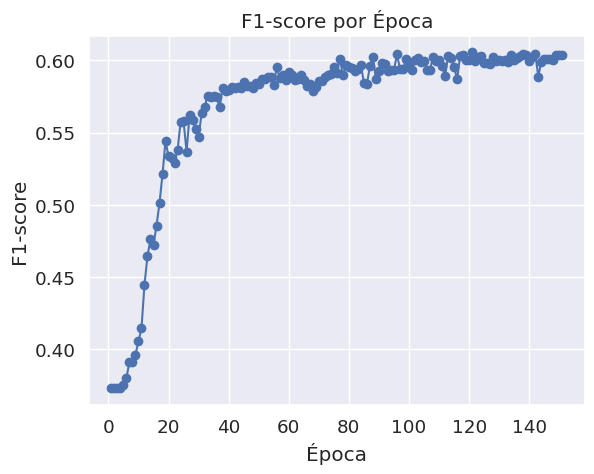

In [124]:
checkpoint_callback.best_model_path
import matplotlib.pyplot as plt

# Después de completar el entrenamiento
epochs = list(range(1, len(pl_model.val_f1_scores) + 1))
plt.plot(epochs, pl_model.val_f1_scores, marker='o')
plt.xlabel('Época')
plt.ylabel('F1-score')
plt.title('F1-score por Época')
plt.grid(True)
plt.show()

In [125]:
best_model = checkpoint_callback.best_model_path
# best_model = "/content/drive/MyDrive/Wav2Vec2_ORVP/wav2vec2_huggingface_fairseq_orvp_test1-epoch=4-step=23459.ckpt"
print(best_model)
test_model = Wav2Vec2_sound_detection.load_from_checkpoint(best_model, hparams=hparams).cuda().eval()

/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v6.ckpt


Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2_ChannelModel: ['lm_head.bias', 'lm_head.weight', 'wav2vec2.feature_extractor.conv_layers.6.conv.weight']
- This IS expected if you are initializing Wav2Vec2_ChannelModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2_ChannelModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2_ChannelModel were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [126]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                            collate_fn = data_collator,
                            shuffle=False, num_workers=0)

You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/cslab03/anaconda3/envs/coEnv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

MulticlassConfusionMatrix()
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6451686024665833
         test_f1            0.6127464175224304
        test_loss           0.6281406879425049
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.6451686024665833,
  'test_f1': 0.6127464175224304,
  'test_loss': 0.6281406879425049}]

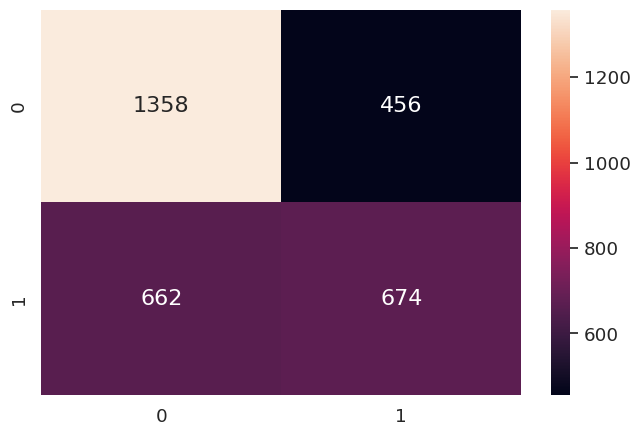

In [127]:
trainer.test(test_model, test_dataloader)

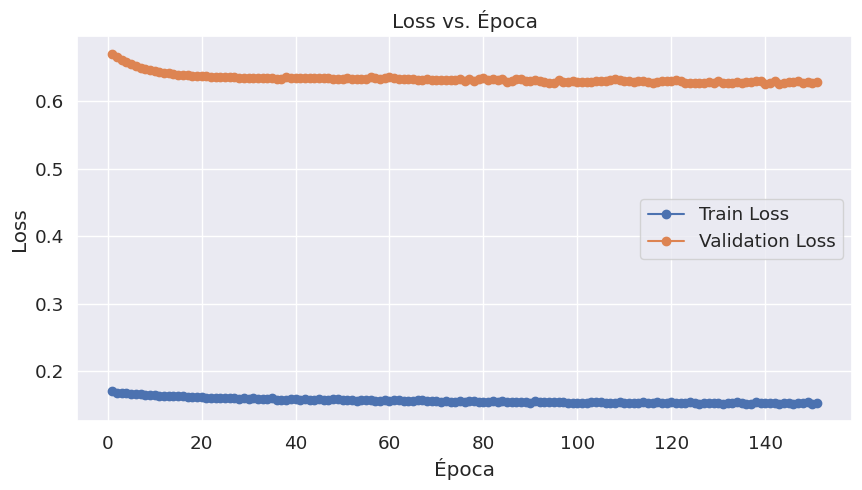

In [128]:
import matplotlib.pyplot as plt

# Después de completar el entrenamiento
epochs = list(range(1, len(pl_model.train_losses) + 1))

plt.figure(figsize=(10, 5))
plt.plot(epochs, pl_model.train_losses, label='Train Loss', marker='o')
plt.plot(epochs, pl_model.val_losses, label='Validation Loss', marker='o')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Loss vs. Época')
plt.legend()
plt.grid(True)
plt.show()


In [182]:
class ANSYN_Dataset_SE_test(torch.utils.data.Dataset):

    def __init__(self, filenames, audio_path):
        self.filenames = [filename for filename in filenames if not any(substring in filename for substring in ['TRBA', 'EXPL', 'VLP', 'TRESP','HB'])]
        self.audio_path = audio_path
    
    def process_audio(self, signal, new_sr):
        # right pad if necessary
        length_signal = signal.shape[1]
        if length_signal < 17787:
            num_missing_samples = 17787 - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        elif length_signal > 17787:
            signal = signal[:, :17787]
            
        return signal
    

    def normalize_layer(self, feats):
        with torch.no_grad():
            feats = torch.nn.functional.layer_norm(feats, feats.shape)
        return feats

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        
        feats, _ = torchaudio.load(self.audio_path + self.filenames[index])
      
                    
        feats = self.process_audio(feats, 16000)
        feats = self.normalize_layer(feats)
        target = torch.tensor(int(self.filenames[index][-6:-4])).long()
        
        return {"input_values": feats, "target": target}
        

In [183]:
X_test = os.listdir('/home/cslab03/Desktop/QuakeWavNet/data1/test_audios/')

In [184]:
X_test[0]

'EC_BREF_632_00.wav'

In [185]:
test_dataset = ANSYN_Dataset_SE_test(X_test, '/home/cslab03/Desktop/QuakeWavNet/data1/test_audios/')

In [186]:
test_dataset.filenames[0][-6:-4]

'00'

In [187]:
test_dataset.__getitem__(1000)

{'input_values': tensor([[-0.0559,  0.0920,  0.2347,  ...,  0.0003,  0.0003,  0.0003]]),
 'target': tensor(0)}

In [188]:
label_distribution = {}
for data in test_dataset:
    label = data["target"].item()
    
    if label == 0:
        label = "LP"
    elif label == 1:
        label = "VT"

        
    if label in label_distribution:
        label_distribution[label] += 1
    else:
        label_distribution[label] = 1

    
print("Label distribution:")
print(label_distribution)


Label distribution:
{'LP': 1044, 'VT': 101}


In [189]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                            collate_fn = data_collator,
                            shuffle=False, num_workers=0)

You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/cslab03/anaconda3/envs/coEnv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

MulticlassConfusionMatrix()
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6235532164573669
         test_f1            0.4500472843647003
        test_loss           0.6506914496421814
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.6235532164573669,
  'test_f1': 0.4500472843647003,
  'test_loss': 0.6506914496421814}]

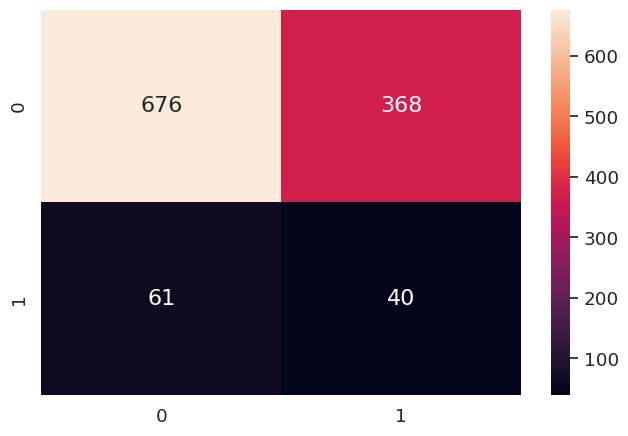

In [190]:
trainer.test(test_model, test_dataloader)